### Final Project

1. orientation
2. velocity

set body length to 1 unit, pool size about 1000x body size?

Notemigonus crysoleucas (golden shiner) and Gambusia holbrooki (mosquitofish)
cap the max velocity at like 50 cm/s so like 10 bodylength per seconds

visual latency is in the order of 10ms

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
from matplotlib import colors
import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import matplotlib.markers as mmarkers
from matplotlib.markers import MarkerStyle
import matplotlib.animation as animation
import matplotlib.cm as cm
import copy

Import fish svg

In [163]:
fih_path, attributes = svg2paths('fih.svg')
fmarker = parse_path(attributes[0]['d'])
fmarker.vertices -= fmarker.vertices.mean(axis=0)
fmarker = fmarker.transformed(mpl.transforms.Affine2D().scale(1,-1))
# plt.plot(1,1,marker = fmarker, markersize = 100)

Initialization

In [164]:
def initialize(numfish, maxcoord, maxvelocity = 10):
    N = numfish #number of fish
    maxvelocity = maxvelocity #bodylength per seconds

    #init coordinations
    motcoords = [np.array([rng.uniform(-maxcoord,maxcoord),rng.uniform(-maxcoord,maxcoord)]) for i in np.arange(N)]

    # init orientations
    radmotangles = [np.array(rng.uniform(0, 2*np.pi)) for i in np.arange(N)]
    degmotangles = np.rad2deg(radmotangles)

    #initialize velocity magnitude array
    # motvelmag = np.zeros(N)
    
    #add initial velocities
    motvelmag = rng.normal(1,0.5,numfish)

    #create a velocity (direction & magnitude) array
    motvel = [np.array((motvelmag[i]*np.cos(radmotangles[i]),motvelmag[i]*np.sin(radmotangles[i]))) for i in np.arange(N)]
    return motcoords, radmotangles, motvelmag, motvel


Rule setting

In [165]:
#get distance to each neighbor
def finddistances(myindex, mycoord, coordarray):
    distances = [np.linalg.norm(mycoord - i) for i in coordarray]
    distances[myindex] = np.nan
    return distances

#define crossproduct
def cross2d(a, b):
    return a[0] * b[1] - a[1] * b[0]

def findnearestneighbor(myindex, mycoord, coordarray):
    dist = finddistances(myindex, mycoord, coordarray)
    neighbor_index = np.nanargmin(dist)
    nearestdist = dist[np.nanargmin(dist)]
    return neighbor_index, nearestdist, dist

def findangletoneighbor(radmyorientation, mycoord, neighborcoord):
    myvector = (np.cos(radmyorientation),np.sin(radmyorientation))
    #get vector from me to you and normalize it
    vector_from_me_to_you = np.subtract(neighborcoord,mycoord)/np.linalg.norm(np.subtract(neighborcoord,mycoord))
    #calculate the dot product and the cross product
    dotproduct = np.dot(myvector, vector_from_me_to_you) 
    crossproduct = cross2d(myvector, vector_from_me_to_you)
    return dotproduct, crossproduct

#first find and index nearest neighbor
testcoord = np.array([0,0])
coords = [np.array([0,0]), np.array([-1,-1]), np.array([2,0]), np.array([0,3]), np.array([-4,3])]
findnearestneighbor(0, testcoord, coords)


(np.int64(1),
 np.float64(1.4142135623730951),
 [nan,
  np.float64(1.4142135623730951),
  np.float64(2.0),
  np.float64(3.0),
  np.float64(5.0)])

In [166]:
def finddistancetonearestwall(mycoord, maxcoord):
    
    xdistance = np.subtract(np.abs(maxcoord), np.abs(mycoord[0]))
    ydistance = np.subtract(np.abs(maxcoord), np.abs(mycoord[1]))

    if mycoord[0] < 0:
        xdistance = -1*xdistance
    else: xdistance = xdistance
    if mycoord[1] < 0:
        ydistance = -1*ydistance
    else: ydistance = ydistance
    return xdistance, ydistance


def findangletowall(radmyorientation, mycoord, maxcoord):
    myvector = np.array([np.cos(radmyorientation),np.sin(radmyorientation)])

    #nearest walls
    xwall, ywall = finddistancetonearestwall(mycoord, maxcoord)

    if xwall != 0:
        xwallvector = np.array([1,0]) if xwall < 0 else np.array([-1,0])
    else: xwallvector = np.array([0,0])
    if ywall != 0:
        ywallvector = np.array([0,1]) if ywall < 0 else np.array([0,-1])
    else: ywallvector = np.array([0,0])
    
    #calculate the dot product and the cross product
    xdotproduct = np.dot(myvector, xwallvector) 
    ydotproduct = np.dot(myvector, ywallvector) 
    xcrossproduct = cross2d(myvector,xwallvector)
    ycrossproduct = cross2d(myvector,ywallvector)
    return xdotproduct, ydotproduct, xcrossproduct, ycrossproduct

coord = (-2,2)
arena = 10

finddistancetonearestwall(coord,arena/2)

(np.float64(-3.0), np.float64(3.0))

Test

In [167]:
# #test
# poolsize = 10
# N = 1
# motcoords, radmotangles, motvelmag, motvel = initialize(N,poolsize/2)

# xcoords, ycoords = zip(*motcoords)

# degmotangles = np.rad2deg(radmotangles)

# fig, ax = plt.subplots()
# # scaling follows s = 160000/x^2 where x is the width of the coordinate
# for i in np.arange(len(motcoords)):
#     rotfmarker = fmarker.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
#     ax.scatter(xcoords[i],ycoords[i], marker = rotfmarker, s = 160000/poolsize**2)

# ax.set_xlim(-poolsize/2,poolsize/2)
# ax.set_ylim(-poolsize/2,poolsize/2)
# ax.grid()
# plt.show()

# print(motcoords)
# print(degmotangles)

# for i in np.arange(N):
#     # print(findangletoneighbor(radmotangles[0], motcoords[0], motcoords[i]))
#     print(finddistancetonearestwall(motcoords[0], poolsize/2))
#     print(findangletowall(radmotangles[0],motcoords[0],poolsize/2))


- Radius of 1 body length = R 
- Speed: (front-back over side-side): This acceleration response was dependent on the fish’s current speed (multiply velocity by a factor)
- Attractive over R => accelerates/decelerates according to front or back
    - accelerate 1 bodylength based on the function cos(theta) where theta is the angle between the fish and its neighbor?
- Maybe some weight over front than back
- Repulsive inside R => accelerates/decelerates according to front or back
- Turn: (relative angle over distance)
- Turn towards neighbor’s position (30-60º rotation depending on relative angle)


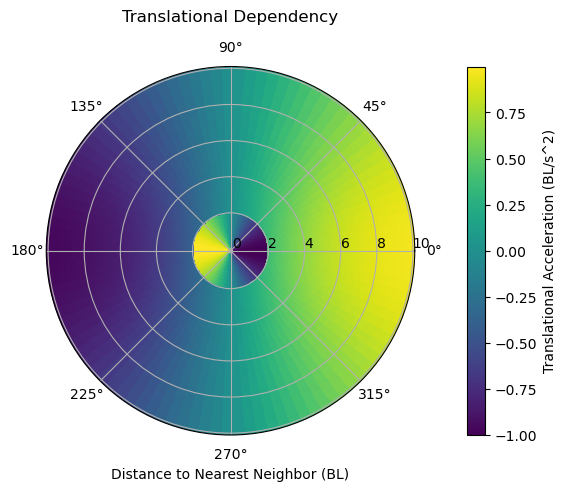

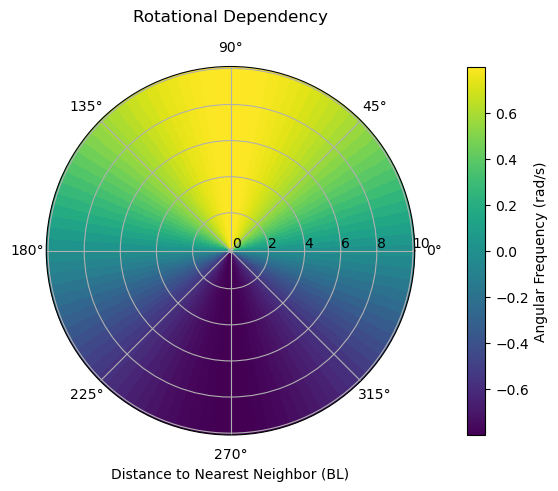

In [168]:
#plot the translational and angular acceleration functions:
r_values = np.linspace(0, 10, 50)  # Radial distances
theta_values = np.linspace(0, 2 * np.pi, 100) # Angles in radians
R, THETA = np.meshgrid(r_values, theta_values)

# Example 'z'data (e.g., a function of r and theta)
Zfar = np.cos(THETA) * np.tanh(R/5)
Zclose = -np.cos(THETA)

Zclose_masked = np.where(R <= 2, Zclose, np.nan)

#consistent Acceleration values for heatmap
Zmin = np.nanmin([Zfar.min(), Zclose.min()])
Zmax = np.nanmax([Zfar.max(), Zclose.max()])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},constrained_layout=True)
heatmapfar = ax.pcolormesh(THETA, R, Zfar, cmap='viridis', vmin=Zmin, vmax=Zmax) # Choose a colormap
heatmapclose = ax.pcolormesh(THETA, R, Zclose_masked, cmap='viridis',vmin=Zmin, vmax=Zmax) # Choose a colormap

fig.colorbar(heatmapfar, ax=ax, label='Translational Acceleration (BL/s^2)')
ax.set_title('Translational Dependency', y= 1.1)
ax.set_rlabel_position(0) # Adjust position of radial labels
ax.set_xlabel("Distance to Nearest Neighbor (BL)")

plt.show()

#Angular acceleration heatmap * np.tanh(R/5)
AAfar = 0.8*np.sin(THETA) 

# AAclose_masked = np.where(R <= 2, AAclose, np.nan)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},constrained_layout=True)
heatmapfar = ax.pcolormesh(THETA, R, AAfar, cmap='viridis') # Choose a colormap

fig.colorbar(heatmapfar, ax=ax, label='Angular Frequency (rad/s)')
ax.set_title('Rotational Dependency', y= 1.1)
ax.set_rlabel_position(0) # Adjust position of radial labels
ax.set_xlabel("Distance to Nearest Neighbor (BL)")

plt.show()



In [ ]:
#run this for all fish in one timestep
#we can also change the fish to only respond to a certain angle of neighbor, like -pi/3 to pi/3 rad
#error about 0.25 maybe, can change

def updatefish(positions,radorientations,speeds,velocity, arenarange = 100, time = 0, timestep = 0.066, maxa = 1.0, maxdw = 0.8, vdecay = 0.8, erroracc = 0, errordw = 0, maxspd = 10):
    copypositions = positions.copy()
    time += timestep
    t = timestep
    N = len(positions)
    maxspeed = maxspd
    maxcoord = arenarange/2
    for i in np.arange(N):
        #first find the nearest neighbor
        neighindex, neighdist, dist = findnearestneighbor(i, copypositions[i], copypositions)
        print(neighdist)
        #find its dotproduct
        dotproduct, crossproduct = findangletoneighbor(radorientations[i],copypositions[i],copypositions[neighindex]) #simply cos(theta) and sin(theta)

        #calculate the accelerations based on the dotproduct and the distance to the neighbor
        motaccpositive = maxa*dotproduct*np.tanh(neighdist/5) + rng.uniform(-erroracc,erroracc)
        motaccnegative = maxa*dotproduct + rng.uniform(-erroracc,erroracc) #assume no huge distance dependence
        dw = maxdw*crossproduct + rng.uniform(-errordw,errordw)
        
        #Speed rule 1, attractve over R (2 body lengths) 
        if neighdist > 2:
            #update velocity magnitude based on where the other fish is. If in front, accelerate, if behind, deccelerate
            if np.abs(speeds[i] + motaccpositive*t) <= maxspeed:
                speeds[i] = max(0, speeds[i] + motaccpositive*t)
            else:
                speeds[i] = speeds[i]
        #speed rule 2, repulsive under R
        elif neighdist < 2:
            #if behind, accelerate forward. if ahead, decelerate
            if np.abs(speeds[i] - motaccnegative*t) <= maxspeed:
                speeds[i] = max(0,speeds[i] - motaccnegative*t)
            else:
                speeds[i] = speeds[i]

        #orientation rule 1, turn towards nearest neighbor
        if neighdist > 2: #radpersecond
            radorientations[i] = radorientations[i] + dw*t
        elif neighdist < 2: #radpersecond
            radorientations[i] = radorientations[i] -  dw*t

        #add repulsive force towards wall
        xwalldist, ywalldist = finddistancetonearestwall(copypositions[i], maxcoord)
        xwalldot, ywalldot, xwallcross, ywallcross = findangletowall(radorientations[i], copypositions[i], maxcoord)
        #angular acceleration for wall
        dwwallx = maxdw*xwallcross + rng.uniform(-errordw,errordw)
        dwwally = maxdw*ywallcross + rng.uniform(-errordw,errordw)

        if np.abs(xwalldist) < 2 and xwalldot < 0:
            radorientations[i] += dwwallx * t
        if np.abs(ywalldist) < 2 and ywalldot < 0:
            radorientations[i] += dwwally * t
        
        #update velocity
        velocity[i] = (speeds[i]*np.cos(radorientations[i]),speeds[i]*np.sin(radorientations[i]))

        #check position so that it is in bounds
        checknewposition = positions[i] + np.array(velocity[i])*t

        #if out of bounds, move fish to 1 BL from border and decelerate to 0, update velocity
        if np.abs(checknewposition[0]) > maxcoord or np.abs(checknewposition[1]) > maxcoord:
            if checknewposition[0] > maxcoord:
                positions[i][0] = maxcoord - 1
            if checknewposition[0] < -maxcoord:
                positions[i][0] = -maxcoord + 1
            if checknewposition[1] > maxcoord:
                positions[i][1] = maxcoord - 1
            if checknewposition[1] < -maxcoord:
                positions[i][1] = -maxcoord + 1
            
            speeds[i] = 0
            velocity[i] = (0,0)
        else: positions[i] = positions[i] + np.array(velocity[i])*t # update position according to x = x+vt for all fish
        
    return positions, radorientations, speeds, velocity, time

Plot and analysis

In [170]:
#plotting function

def plot(coords, radorientations, viewrange = (-50,50), title = '', fishmarker = fmarker):
    figurelength = viewrange[1]-viewrange[0]
    degmotangles = np.rad2deg(radorientations)

    xcoords, ycoords = zip(*coords)
    N = len(coords)
    colors = cm.rainbow(np.linspace(0, 1, N))
    
    fig, ax = plt.subplots()
    # scaling follows s = 160000/x^2 where x is the width of the coordinate

    for i in np.arange(N):
        rotmarker = fishmarker.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
        ax.scatter(xcoords[i],ycoords[i], marker = rotmarker, s = 160000/figurelength**2, color = colors[i])

    #plot view range
    ax.set_xlim(viewrange[0],viewrange[1])
    ax.set_ylim(viewrange[0],viewrange[1])

    ax.set_title(title)
    ax.grid()
    plt.show()


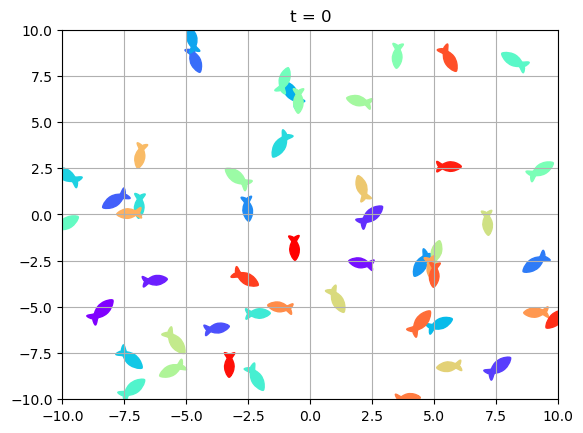

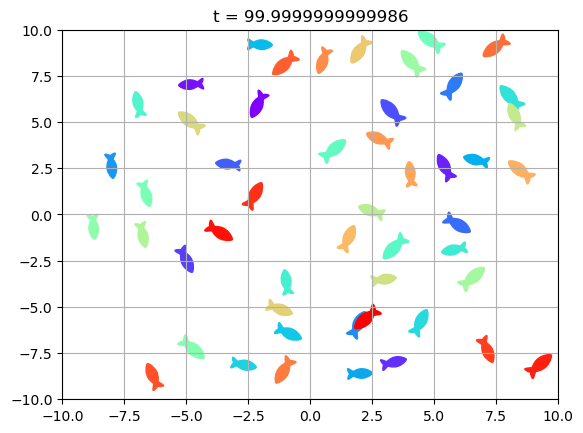

In [171]:
numiterations = 1000
poolrange = 20 #poolrange/2 is the length of each side
initcoordmax = 10 #essentially initial density
numfish = 50
inittime = 0
positionarray = []
speedarray = []

pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = 't = 0')

#run the function numiteration times and keep track of positions
for i in np.arange(numiterations):
    pos, motorientations, motspeeds, motvelocity, inittime = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange)
    speedarray.append(copy.deepcopy(motspeeds))
    positionarray.append(copy.deepcopy(pos))

plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = f't = {inittime}')


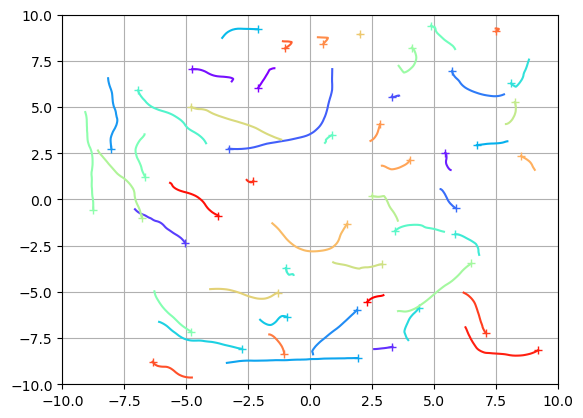

In [172]:
#trajectory plot
fig, ax = plt.subplots()

plotmaxcoord = poolrange/2
trajlength = 50

colors = cm.rainbow(np.linspace(0, 1, numfish))

for n in np.arange(numfish):
    coordinates = []
    for i in np.arange(numiterations):
        coordinates.append(positionarray[i][n])
    fishcoordsx, fishcoordsy = zip(*coordinates)

    recent_x = fishcoordsx[-trajlength:]
    recent_y = fishcoordsy[-trajlength:] 

    ax.plot(recent_x, recent_y, color=colors[n])
    ax.plot(recent_x[-1], recent_y[-1], marker='+', color=colors[n])

ax.set_xlim(-plotmaxcoord,plotmaxcoord)
ax.set_ylim(-plotmaxcoord,plotmaxcoord)
ax.grid()
plt.show()


In [173]:
#final velocity plot function
def plotvel(coords, radorientations, speeds, viewrange = (-50,50), title = ''):
    markerstyle = MarkerStyle(marker= '_')

    figurelength = viewrange[1]-viewrange[0]
    degmotangles = np.rad2deg(radorientations)

    xcoords, ycoords = zip(*coords)
    N = len(coords)
    
    fig, ax = plt.subplots()

    # scaling of the length is proportional to the velocity
    for i in np.arange(N):
        rotmarker = markerstyle.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
        scale = speeds[i]
        ax.scatter(xcoords[i],ycoords[i], marker = rotmarker, s = 100*scale)

    #plot view range
    ax.set_xlim(viewrange[0],viewrange[1])
    ax.set_ylim(viewrange[0],viewrange[1])

    ax.set_title(title)
    ax.grid()

    plt.show()

[0.40117031 0.7300813  0.30589022 1.24071181 1.05000557 0.15443105
 1.80738046 0.         0.         0.         0.86655668 0.51171256
 0.         0.         0.35418071 0.9004701  0.99663191 0.56834875
 0.08611626 0.70694858 0.65232493 0.70118949 0.44291467 0.33678329
 0.96940067 0.89488758 0.86713066 0.54885448 0.99318905 0.52783071
 0.52837768 0.         0.62617861 0.51731295 0.         0.
 0.93622496 0.65998947 0.01566948 0.         0.00575615 0.
 0.3069783  0.75844853 0.38543981 0.60405903 0.         0.93788139
 1.03472966 0.        ]


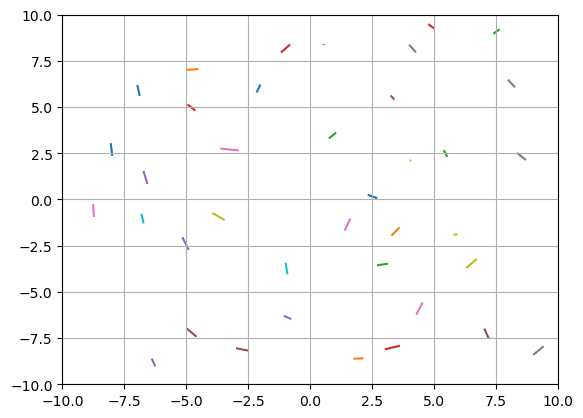

In [ ]:
#final velocity plot:
print(motspeeds)
plotvel(pos, motorientations, motspeeds, viewrange = (-plotmaxcoord,plotmaxcoord))

np.float64(0.4907834964379656)

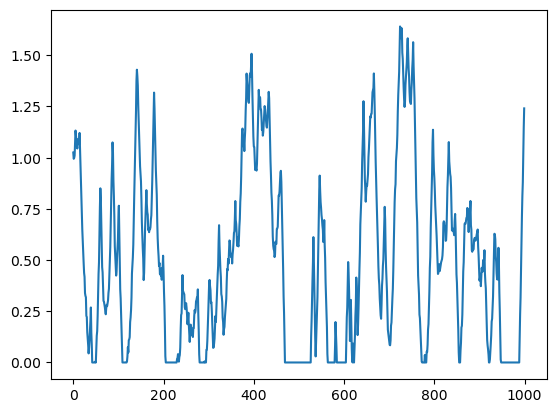

In [181]:
#plot changes in speed:
speedarray
speedonefish = [array[3] for array in speedarray]
plt.plot(np.arange(len(speedonefish)),speedonefish)
np.mean(speedonefish)


In [176]:
# fig, ax = plt.subplots()


# for i in np.arange(N):
#     fmarker = fmarker.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
#     ax.scatter(xcoords[i],ycoords[i], marker = fmarker, s = 160000/poolsize**2)

# ax.set_xlim(0,poolsize)
# ax.set_ylim(0,poolsize)
# ax.grid()

# # title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
# #                 transform=ax.transAxes, ha="center")

# totaliter = 500

# # Use consistent variable name and properly update the lattice
# for i in range(totaliter):
#     for i in range(current_lattice.size):
#         current_lattice = metrosimcompact(current_lattice)  # Update properly
#     arrayoflat.append(current_lattice.copy())  # Store a copy

# def animatefunc(frame):
#     nextlat = arrayoflat[frame]
#     im.set_array(nextlat)
#     title.set_text(f'Frame: {frame}')
#     return im,

# ani = animation.FuncAnimation(fig, animatefunc, frames=totalsweeps, interval=10, blit=True)
# ani.save('newnewising.gif', writer='pillow')
# print('done')

Analysis

For different error values 
Polarization for different error
Cohesion for different error
Milling for different error
average center of mass speed 
average center of mass position

also there's a weird thing happening where the fish always end up in the first quadrant

In [177]:
#center of mass

def findCM(positionarray):
    N = len(positionarray)
    sum = np.sum(positionarray, axis = 0)
    centerofmass = sum/N
    return centerofmass

def findVCM(velocityarray):
    N = len(velocityarray)
    sum = np.sum(velocityarray, axis = 0)
    Vcm = sum/N
    return Vcm

def findP(radorientations):
    N = len(radorientations)
    #normalize the velocities => basically [cos(angle),sin(angle)]
    normvel = [np.array([np.cos(i),np.sin(i)]) for i in radorientations]
    #add them up
    NormVsum = np.sum(normvel, axis = 0)
    #take the magnitude of the sum
    mag = np.linalg.norm(NormVsum)
    #divide by N
    P = mag/N
    return P

def findCohesion(positionarray):
    N = len(positionarray)
    cm = findCM(positionarray)
    distfromcm = [np.linalg.norm(coords-cm) for coords in positionarray] 
    distsquared = np.square(distfromcm)
    distsqsum = np.sum(distsquared, axis = 0)
    cohesion = np.sqrt(distsqsum/N)
    return cohesion

def findMilling(positionarray, radorientations):
    N = len(positionarray)
    normvel = [np.array([np.cos(i),np.sin(i)]) for i in radorientations]
    print(f'normvel {normvel}')
    normpos = [position/np.linalg.norm(position) for position in positionarray]
    print(f'normpos {normpos}')

    crossp = [cross2d(normpos[i], normvel[i]) for i in np.arange(N)]
    print(f'crossp {crossp}')

    sumofcrossp = np.sum(crossp, axis = 0)
    print(f'sum {sumofcrossp}')

    milling = np.abs(sumofcrossp)/N

    return milling

